# A few simple corpus-driven approaches to narrative analysis and generation

By [Allison Parrish](http://www.decontextualize.com/)

This notebook is a fast introduction to a few techniques for working with narrative corpora. By "narrative corpora," I mean pre-existing bodies of text that mostly contain the texts of narratives. In particular, we're going to use Mark Riedl's [WikiPlots corpus](https://github.com/markriedl/WikiPlots), which has the titles and plot summaries of more than one hundred thousand movies, books, television shows and other media from Wikipedia.

The notebook takes you through using [spaCy](http://spacy.io) to extract words, noun chunks, parts of speech and entities from the text and then sew them back together with [Tracery](http://tracery.io). It then shows how to use [Markovify](https://github.com/jsvine/markovify) to create new narratives from existing narrative text, and how to prepare the narratives for use as a training corpus for a large pre-trained language model like GPT-2.

The code is written in Python, but you don't really need to know Python in order to use the notebook. Everything's pre-written for you, so you can just execute the cells, making small changes to the code as needed. Even if the notebook itself doesn't end up being useful to you, hopefully it spurs a few ideas that you can take with you into your practice as a storyteller and/or programmer.

If you're running this code on Binder, you should be good to go. Just keep on executing the cells below. If you're running this notebook on Google Colab, you'll need to run the following cells to install the necessary libraries and download the data:

In [4]:


!curl -L -O https://github.com/aparrish/corpus-driven-narrative-generation/raw/master/romcom_plot_sentences.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0 4014k    0  6855    0     0   2668      0  0:25:40  0:00:02  0:25:38  2668
 53 4014k   53 2136k    0     0   654k      0  0:00:06  0:00:03  0:00:03 3059k
100 4014k  100 4014k    0     0  1157k      0  0:00:03  0:00:03 --:--:-- 4447k


## Loading the corpus

The first step is to get the narrative corpus into the program. Because WikiPlots is so big, we're actually going to be working with a smaller subset: only the plot summaries for romantic comedy movies. The subcorpus was made using [this notebook on creating a subcorpus of WikiPlots](https://github.com/aparrish/corpus-driven-narrative-generation/blob/master/creating-a-wikiplots-subcorpus.ipynb), which you can consult if you want to make your own with a different subset of WikiPlots.

The corpus we're working with takes the form of a TSV file ("tab separated values"), with each line containing the title of the movie, a number indicating where in the plot summary the sentence for this line occurs, the total number of sentences in the summary, and the actual text of the sentence. The following cell loads the data into a list of dictionaries:

In [2]:
global sentences
sentences = []
# for line in open("romcom_plot_sentences.tsv",encoding='utf-8'):
#    line = line.strip()
#    items = line.split("\t")
#    sentences.append(
#    {'title': items[0],
#    'index': int(items[1]),
#    'total': int(items[2]),
#    'text': items[3]})

import csv

firstpath = "C:/Users/aarya/Downloads/preprocessed_data.csv/aaryan2.txt"
    
for line in open(firstpath,encoding='utf-8'):
    line = line.strip()
    #print(line)
    csv.reader(firstpath, delimiter = ".")
    items = line.split("#")
    #print(items[0]);
    #print(items[1]);
    sentences.append(
        {'title': items[0], 
         'text': items[1],
         'classification': items[5],
        })
    #print(sentences)
    
# with open(firstpath, 'r') 
#    reader = csv.reader(file, delimiter = ".")
#    for row in reader:
#        print(row)

IndexError: list index out of range

Just to make sure it worked, we'll print out a random sentence:

In [3]:
import random as random

random.choice(sentences)

{'title': 'FOUR BEASTS IN ONE—THE HOMO-CAMELEOPARD',
 'text': 'Chacun a ses vertus. —Crebillon’s Xerxes.  ANTIOCHUS EPIPHANES is very generally looked upon as the Gog of the prophet Ezekiel. This honor is, however, more properly attributable to Cambyses, the son of Cyrus. And, indeed, the character of the Syrian monarch does by no means stand in need of any adventitious embellishment. His accession to the throne, or rather his usurpation of the sovereignty, a hundred and seventy-one years before the coming of Christ; his attempt to plunder the temple of Diana at Ephesus; his implacable hostility to the Jews; his pollution of the Holy of Holies; and his miserable death at Taba, after a tumultuous reign of eleven years, are circumstances of a prominent kind, and therefore more generally noticed by the historians of his time than the impious, dastardly, cruel, silly, and whimsical achievements which make up the sum total of his private life and reputation.   Let us suppose, gentle reader,

Note: You can make your own corpus that works with the code in this notebook by exporting your data in TSV format with one line per sentence, with columns for the following:

* `title`: the title of the work that the sentence comes from
* `index`: the index of the sentence in the work
* `total`: the total number of sentences in the work
* `text`: the text of the sentence

## Natural language processing

To get an idea of what's happening in the text of the plots, we can do a bit of Natural Language Processing. I cover just the bare essentials in this notebook. [Here's a more in-depth tutorial that I wrote](https://github.com/aparrish/rwet/blob/master/nlp-concepts-with-spacy.ipynb).

Most natural language processing is done with the aid of third-party libraries. We're going to use one called spaCy. To use spaCy, you first need to install it (i.e., download the code and put it in a place where Python can find it) and download the language model. (The language model contains statistical information about a particular language that makes it possible for spaCy to do things like parse sentences into their constituent parts.)

Run the following cell to load spaCy's model:

In [4]:
import os
import sys
!{sys.executable} -m spacy info 
import time
import spacy

nlp = spacy.load('en_core_web_md')



============================== Info about spaCy ==============================

spaCy version    3.3.1                         
Location         C:\Users\aarya\anaconda3\lib\site-packages\spacy
Platform         Windows-10-10.0.22000-SP0     
Python version   3.9.12                        
Pipelines        en_core_web_md (3.3.0), en_core_web_sm (3.3.0)



### (This could also take a while–the model is potentially very large and your computer needs to load it from your hard drive and into memory. When you see a `[*]` next to a cell, that means that your computer is still working on executing the code in the cell.)

Right off the bat, the spaCy library gives us access to a number of interesting units of text:

* All of the sentences (`doc.sents`)
* All of the words (`doc`)
* All of the "named entities," like names of places, people, #brands, etc. (`doc.ents`)
* All of the "noun chunks," i.e., nouns in the text plus surrounding matter like adjectives and articles

The cell below, we extract these into variables so we can play around with them a little bit. (Parsing sentences is hungry work and the following cell will take a while to execute.)

0 6


Just to make sure it worked, print out ten random words:

In [6]:
for item in random.sample(words, 10):
    print(item.text)

patronize
is
of
then
regard
premises
the
phrensied
now
the


Ten random noun chunks:

In [7]:
for item in random.sample(noun_chunks, 100):
    print(item.text)

God
an end
the promises
who
which
he
This one
awe
you
some persons
every thing
the finest India lawn
a man’s mind
the heavens
I
youth
it
it
the counter
blood
a breeze
the fervor
the contents
c.
which
your way
I
their escape
which
a single draught
the agony
ourselves
people
the converse
the phrase
the purpose
it
paper
, Antiochus Epimanes
the Zephyrs
victory
this
other men
themselves
any other shape
myself
they
the sea
You
the president
decorum
you
three feet
Bottles
the top
the undertaker
him
they
they
Hop-Frog
nothing
calm weather
who
it
rapid notice
you
which
the bow
misadventure
His frame
a sinner
existence
their own enormity
occasion
jugs
teeth
his ears
Eleonora
his arms
the chain
the rainbow
ourselves
a dropsy
a huge writhing wall
the memorials
the mere knowledge
sable hearse-plumes
the Illustrious!—also ‘Prince
he
surge
account
the most amazing velocity
His face
a hurried prayer
the head
your chance
the cotton drawers
the vanities
horror
the thing


# Ten random entities:

In [8]:
#for item in random.sample(entities, 10):
#    print(item.text)
for in t

Moneypenny
Mille
Norwegian
Mneme
Psyche
Philadelphia
Vurrgh
Ermengarde
Alexander the Great
first


### Grammatical roles

The parser included with spaCy can also give us information about the grammatical roles in the sentence. For example, the `.root.dep_` attribute of a noun chunk tells us whether that noun chunk is the subject of the sentence ("nsubj") or a direct object ("dobj") of the sentence. (See the "Universal Dependency Labels" of spaCy's [annotation specs](https://spacy.io/api/annotation) for more possible roles.) Using this information, we can make a list of sentence subjects and sentence objects:

In [9]:
subjects = [chunk for chunk in noun_chunks if chunk.root.dep_ == 'nsubj']
objects = [chunk for chunk in noun_chunks if chunk.root.dep_ == 'dobj']

In [10]:
random.sample(subjects, 10)

[you,
 I,
 me,
 us,
 whose tall slender,
 the valley,
 The ways,
 I,
 the largest ship,
 I]

In [11]:
random.sample(objects, 10)

[an Allegory,
 whom,
 this tone,
 a depth,
 anything,
 you,
 its way,
 yourself,
 no idea,
 a noise]

### Parts of speech

The spaCy parser allows us to check what part of speech a word belongs to. In the cell below, we create four different lists—`nouns`, `verbs`, `adjs` and `advs`—that contain only words of the specified parts of speech. Using the `.tag_` attribute, we can easily get only particular forms of verbs; in this case, I'm just getting verbs that are in the past tense. ([There's a full list of part of speech tags here](https://spacy.io/docs/usage/pos-tagging#pos-tagging-english).)

In [12]:
nouns = [w for w in words if w.pos_ == "NOUN"]
verbs = [w for w in words if w.pos_ == "VERB"]
past_tense_verbs = [w for w in words if w.tag_ == 'VBD']
adjs = [w for w in words if w.tag_ == "JJ"]
advs = [w for w in words if w.pos_ == "ADV"]

And now we can print out a random sample of any of these:

In [13]:
for item in random.sample(nouns, 12): # change "nouns" to "verbs" or "adjs" or "advs" to sample from those lists!
    print(item.text)

celebration
story
foam
manner
heavens
occasion
wretch
shop
rivulets
seamen
laughter
ladies


### Entity types

The parser in spaCy not only identifies "entities" but also assigns them to a particular type. [See a full list of entity types here.](https://spacy.io/docs/usage/entity-recognition#entity-types) Using this information, the following cell builds lists of the people, locations, and times mentioned in the text:

In [14]:
people = [e for e in entities if e.label_ == "PERSON"]
locations = [e for e in entities if e.label_ == "LOC"]
times = [e for e in entities if e.label_ == "TIME"]

And then you can print out a random sample:

In [15]:
for item in random.sample(people, 10): # change "times" to "people" or "locations" to sample those lists
    print(item.text.strip())

cameleopard
Moneypenny
Helseggen
Eros
B.‘s
Blackwood
Zenobia
Caryatides
Ben Nevis
kai palin


### Finding the most common

We won't go too deep into text analysis in this tutorial, but it's useful to be able to do the most fundamental task in text analysis: finding the things that are most common. The code to do this task looks like the following, which gives us a way to look up how often any word occurs in the text:

In [16]:
from collections import Counter
word_count = Counter([w.text for w in words])

In [17]:
word_count['Meanwhile']

0

... and also tells us which words are most common:

In [18]:
word_count.most_common(12)

[('the', 1749),
 ('of', 1058),
 ('and', 779),
 ('a', 577),
 ('to', 564),
 ('in', 449),
 ('I', 318),
 ('that', 264),
 ('was', 251),
 ('it', 220),
 ('is', 204),
 ('as', 204)]

You can make a counter for any of the other lists we've worked with using the same syntax. Just make up a unique variable name on the left of the `=` sign and put the name of the list you want to count in the brackets to the right (replacing `words`). E.g., to find the most common people:

In [19]:
people_count = Counter([w.text for w in people])

In [57]:
global mainC
mainC = people_count.most_common(1)
global properNoun
for item, count in mainC:
    print(item)
properNoun = item

Eleonora


The most common past-tense verbs:

In [21]:
vbd_count = Counter([w.text for w in past_tense_verbs])

In [22]:
vbd_count.most_common(12)

[('was', 251),
 ('had', 138),
 ('were', 82),
 ('made', 25),
 ('said', 21),
 ('seemed', 20),
 ('did', 16),
 ('came', 15),
 ('took', 15),
 ('lay', 12),
 ('appeared', 11),
 ('arose', 10)]

### Writing to a file

The following cell defines a function for writing data from a `Counter` object to a file. The file is in "tab-separated values" format, which you can open using most spreadsheet programs. Execute it before you continue:

In [23]:
def save_counter_tsv(filename, counter, limit=1000):
    with open(filename, "w", encoding="utf-8") as outfile:
        outfile.write("key\tvalue\n")
        for item, count in counter.most_common():
            outfile.write(item.strip() + "\t" + str(count) + "\n")    

Now, run the following cell. You'll end up with a file in the same directory as this notebook called `100_common_words.tsv` that has two columns, one for the words and one for their associated counts:

In [24]:
save_counter_tsv("100_common_words.tsv", word_count, 100)

Try opening this file in Excel or Google Docs or Numbers!

If you want to write the data from another `Counter` object to a file:

* Change the filename to whatever you want (though you should probably keep the `.tsv` extension)
* Replace `word_count` with the name of any of the `Counter` objects we've made in this sheet and use it in place of `word_count`
* Change the number to the number of rows you want to include in your spreadsheet.

### When do things happen in this text?

Here's another example. Using the `times` entities, we can make a spreadsheet of how often particular "times" (durations, times of day, etc.) are mentioned in the text.

In [25]:
time_counter = Counter([e.text.lower().strip() for e in times])
save_counter_tsv("time_count.tsv", time_counter, 100)

Do the same thing, but with people:

In [26]:
people_counter = Counter([e.text.lower() for e in people])
save_counter_tsv("people_count.tsv", people_counter, 100)

### Generating stories from a corpus and Tracery grammars

Once you've isolated entities and parts of speech, you can recombine them in interesting ways. One is to use a Tracery grammar to write sentences that include the isolated parts. Because the parts have been labelled using spaCy, you can be reasonbly sure that they'll fit into particular slots in the sentence. (I used a similar technique for my [Cheap Space Nine](https://twitter.com/cheapspacenine) bot.)

In [27]:
import tracery
from tracery.modifiers import base_english

In [28]:
rules = {
    "subject": [w.text for w in subjects],
    "object": [w.text for w in objects],
    "verb": [w.text for w in past_tense_verbs if w.text not in ('was', 'were', 'went')], # exclude common irregular verbs
    "adj": [w.text for w in adjs],
    "people": [w.text for w in people],
    "loc": [w.text for w in locations],
    "time": [w.text for w in times],
    "origin": "#scene#\n\n[charA:#subject#][charB:#subject#][prop:#object#]#sentences#",
    "scene": "SCENE: #loc#, #time.lowercase#",
    "sentences": [
        "#sentence#\n#sentence#",
        "#sentence#\n#sentence#\n#sentence#",
        "#sentence#\n#sentence#\n#sentence#\n#sentence#"
    ],
    "sentence": [
        "#charA.capitalize# #verb# #prop#.",
        "#charB.capitalize# #verb# #prop#.",
        "#prop.capitalize# became #adj#.",
        "#charA.capitalize# and #charB# greeted each other.",
        "'Did you hear about #object.lowercase#?' said #charA#.",
        "'#subject.capitalize# is #adj#,' said #charB#.",
        "#charA.capitalize# and #charB# #verb# #object#.",
        "#charA.capitalize# and #charB# looked at each other.",
        "#sentence#\n#sentence#"
    ]
}

In [29]:
grammar = tracery.Grammar(rules)
grammar.add_modifiers(base_english)

In [30]:
for i in range(3):
    print(grammar.flatten("#origin#"))
    print()

SCENE: the River of Silence, all night

It made her whole appearance.
It took her whole appearance.

SCENE: the Valley of the Many-Colored Grass, all night

Me on.—Years spoke the fancy.
Me on.—Years and That looked at each other.
'Did you hear about his torch?' said me on.—Years.

SCENE: the Valley of the Many-Colored Grass, the earlier hours

Which and that greeted each other.
'Did you hear about a son?' said which.
It became other.
'The gods is true,' said that.
That occurred it.
It became aware.



## Markov chain text generation

Another way to produce new narratives from existing narrative text is to find statistical patterns in the text itself and then make the computer create new text that follows those statistical patterns. Markov chain text generation has been a pastime of poets and programmers going back [all the way to 1983](https://www.jstor.org/stable/24969024), so it should be no surprise that there are many implementations of the idea in Python that you can download and install. The one we're going to use is [Markovify](https://github.com/jsvine/markovify), a Markov chain text generation library originally developed for BuzzFeed, apparently. Writing [code to implement a Markov chain generator](https://github.com/aparrish/rwet/blob/master/ngrams-and-markov-chains.ipynb) on your own is certainly possible, but Markovify comes with a lot of extra niceties that will make our lives easier.

To install Markovify on your computer, run the cell below. (You can skip this step if you're using this notebook in Binder.)

In [175]:
!pip install markovify

And then run this cell to make the library available in your notebook:

In [31]:
import markovify

We need a list of strings to train the Markov generator. For now, let's just get all of the sentences from any movie in the corpus:

In [33]:
all_text = [item['text'] for item in sentences]

The code in the following cell creates a new text generator, using the text in the variable specified to build the Markov model, which is then assigned to the variable `all_text_gen`.

In [34]:
all_text_gen = markovify.Text(all_text)

You can then call the `.make_sentence()` method to generate a sentence from the model:

In [35]:
print(all_text_gen.make_sentence())

Pest-spirits, plague-goblins, and fever-demons, were the only thing on deck that had never let go of the novel which confounds the beholder.


The `.make_short_sentence()` method allows you to specify a maximum length for the generated sentence:

In [36]:
print(all_text_gen.make_short_sentence(10))

None


By default, Markovify tries to generate a sentence that is significantly different from any existing sentence in the input text. As a consequence, sometimes the `.make_sentence()` or `.make_short_sentence()` methods will return `None`, which means that in ten tries it wasn't able to generate such a sentence. You can work around this by increasing the number of times it tries to generate a sufficiently unique sentence using the `tries` parameter:

In [37]:
print(all_text_gen.make_short_sentence(40, tries=100))

I fancy I know to be a fact.


Or by disabling the check altogether with `test_output=False`:

In [38]:
print(all_text_gen.make_short_sentence(40, test_output=False))

That?—oh, nothing!


### Changing the order

When you create the model, you can specify the order of the model using the `state_size` parameter. It defaults to 2. Let's make two model with different orders and compare:

In [39]:
gen_1 = markovify.Text(all_text, state_size=1)
gen_4 = markovify.Text(all_text, state_size=4)

In [40]:
print("order 1")
print(gen_1.make_sentence(test_output=False))
print()
print("order 4")
print(gen_4.make_sentence(test_output=False))

order 1
You need of my heart refused, even upon my principal street, which escape those who goes properly dressed in a troop of this chaining arrangement was here and his tall flamingo, hitherto unseen, with wild gyrations in such credit as the principal grief than sufficiently aware.

order 4
Mr. B. merely cuts out and intersperses.


In general, the higher the order, the more the sentences will seem "coherent" (i.e., more closely resembling the source text). Lower order models will produce more variation. Deciding on the order is usually a matter of taste and trial-and-error.

### Changing the level

Markovify, by default, works with *words* as the individual unit. It doesn't come out-of-the-box with support for character-level models. The following code defines a new kind of Markovify generator that implements character-level models. Execute it before continuing:

In [41]:
class SentencesByChar(markovify.Text):
    def word_split(self, sentence):
        return list(sentence)
    def word_join(self, words):
        return "".join(words)

Any of the parameters you passed to `markovify.Text` you can also pass to `SentencesByChar`. The `state_size` parameter still controls the order of the model, but now the n-grams are characters, not words.

The following cell implements a character-level Markov text generator for the word "condescendences":

In [42]:
con_model = SentencesByChar("condescendences", state_size=2)

Execute the cell below to see the output—it'll be a lot like what we implemented by hand earlier!

In [43]:
con_model.make_sentence()

'condescencences'

Of course, you can use a character-level model on any text of your choice. So, for example, the following cell creates a character-level order-7 Markov chain text generator from text A:

In [44]:
gen_char = SentencesByChar(all_text, state_size=7)

And the cell below prints out a random sentence from this generator. (The `.replace()` is to get rid of any newline characters in the output.)

In [45]:
print(gen_char.make_sentence(test_output=False))

The masquerade, by eight corpse, advanced to stay all night appointed for vigor of fancy I know the year of the winding-sheet of the ocean, in the ceiling.


### Thinking about structure

It's one thing to be able to produce one plausible sentence of a plot summary using Markov chains, but another to create a sense of overall structure between sentences, and generating narratives with these kinds of long-term dependencies is still an open problem in computational creativity. The approach I'm going to suggest below relies on the intuition that sentences in a plot summary share characteristics based on their position in the summary. First sentences will generally introduce characters and present an initial situation; last sentences will generally describe how the situation was resolved; and sentences in between will describe developing action.

Following this intuition, let's create *three different Markov chains*: one for beginning sentences, one for middle sentences, and one for final sentences. We can use the `index` of each sentence in our corpus to give us this information.

First, the beginnings are lines whose index is zero (i.e., they're the first sentence for this plot):

In [85]:
#beginnings = [line['text'] for line in sentences if line['index'] == 0]
#beginnings = [line['text'] for line in sentences]
#global numLine
#for line in sentences():
    #numLine+=1
    #if numLine = 1:
#lineTemp = sentences[1]
#lineArr = lineTemp.split(".")
#numSentences = len(lineArr)
#print(numsentences)
for i, sent in enumerate(sentences):
    twords = []
    tnoun_chunks = []
    tentities = []
    tplot = []
    # only use 1000 sentences sampled at random by default; comment out this `for...`
    # uncomment the `for...` beneath to use every setence in the corpus.
#for i, sent in enumerate(sentences):
    if i % 100 == 0:
        print(i, len(sentences))
    tdoc = nlp(sent['text'])
    tplot.append(tdoc)
    twords.extend([w for w in list(tdoc) if w.is_alpha])
    tnoun_chunks.extend(list(tdoc.noun_chunks))
    tentities.extend(list(tdoc.ents))
    tpeople = [e for e in tentities if e.label_ == "PERSON"]
    tpeople_count = Counter([w.text for w in tpeople])
    mainC = tpeople_count.most_common(1)
    tproperNoun = ""
    for item, count in mainC:
        tproperNoun = item
    print(tproperNoun)
    #if i % 100 == 0:
        #print(i, len(sentences))
    lineTemp = sent['text'] 
    lineTemp=lineTemp.lstrip('\"')
    #lineTemp=lineTemp.rstrip('”')
    #lineTemp=lineTemp.rstrip()
    lineArr = lineTemp.split(".")
    numSentences = len(lineArr)
    #print(numSentences)
    beginnings = ""
    cnt=0
    begLineNum=0
    for eachline in lineArr:
        if eachline.__contains__(tproperNoun):
            beginnings=eachline
            begLineNum=cnt
            break
        cnt+=1
    if begLineNum == 0:
        beginnings=lineArr[0]
        begLineNum=0
    print(beginnings)
    print(begLineNum)
    endings=lineArr[numSentences-2]
    #print(endings)
    #i=0
    #for eachline in lineArr():
    #    if i != 0 or i != numsentences-2
    #lineArr[0:numsentences-2:]   
    middles=""
    i=0
    endPart = numSentences-2
    for eachline in lineArr:
        if i > begLineNum and i < endPart:
            if middles != "":
                middles=middles + ". " + eachline
            else:
                middles=eachline
        i+=1
    #print(middles)

0 6
Helseggen
 The mountain upon whose top we sit is Helseggen, the Cloudy
13
Eleonora
 Eleonora was the name of my cousin
12
Epiphanes
 Do you not perceive that the animal has the visage of a man? Why, my dear sir, that cameleopard is no other than Antiochus Epiphanes, Antiochus the Illustrious, King of Syria, and the most potent of all the autocrats of the East! It is true, that he is entitled, at times, Antiochus Epimanes—Antiochus the madman—but that is because all people have not the capacity to appreciate his merits
80
Voltaire
 He would have preferred Rabelais’ ‘Gargantua’ to the ‘Zadig’ of Voltaire: and, upon the whole, practical jokes suited his taste far better than verbal ones
9
Blackwood
 as any to be found even in Blackwood
88
Hugh Tarpaulin
   At the precise period, then, when this history properly commences, Legs, and his fellow Hugh Tarpaulin, sat, each with both elbows resting upon the large oaken table in the middle of the floor, and with a hand upon either cheek
21


In [83]:
random.sample(beginnings, 1)

['n']

In [ ]:
# mainC = most common name in the story
for i, sent in enumerate(sentences):
    

And endings are sentences that come last in the plot (i.e., their index is one less than the total number of sentences):

In [51]:
#endings = [line['text'] for line in sentences if line['index'] == line['total'] - 1]
endings = [line['text'] for line in sentences if line]

In [50]:
random.sample(endings, 1)

['"Sub conservatione formae specificae salva anima.  Raymond Lully.    I AM come of a race noted for vigor of fancy and ardor of passion. Men have called me mad; but the question is not yet settled, whether madness is or is not the loftiest intelligence—whether much that is glorious—whether all that is profound—does not spring from disease of thought—from moods of mind exalted at the expense of the general intellect. They who dream by day are cognizant of many things which escape those who dream only by night. In their gray visions they obtain glimpses of eternity, and thrill, in awakening, to find that they have been upon the verge of the great secret. In snatches, they learn something of the wisdom which is of good, and more of the mere knowledge which is of evil. They penetrate, however, rudderless or compassless into the vast ocean of the “light ineffable,” and again, like the adventures of the Nubian geographer, “agressi sunt mare tenebrarum, quid in eo esset exploraturi.”     We 

And "middles" are anything in between:

In [48]:
middles = [line['text'] for line in sentences ]

In [49]:
random.sample(middles, 1)

['"The ways of God in Nature, as in Providence, are not as our ways; nor are the models that we frame any way commensurate to the vastness, profundity, and unsearchableness of His works, which have a depth in them greater than the well of Democritus. Joseph Glanville.    WE had now reached the summit of the loftiest crag. For some minutes the old man seemed too much exhausted to speak.     “Not long ago,” said he at length, “and I could have guided you on this route as well as the youngest of my sons; but, about three years past, there happened to me an event such as never happened to mortal man—or at least such as no man ever survived to tell of—and the six hours of deadly terror which I then endured have broken me up body and soul. You suppose me a very old man—but I am not. It took less than a single day to change these hairs from a jetty black to white, to weaken my limbs, and to unstring my nerves, so that I tremble at the least exertion, and am frightened at a shadow. Do you know

The following cell creates the models:

In [52]:
beginning_gen = markovify.Text(beginnings)
middle_gen = markovify.Text(middles)
ending_gen = markovify.Text(endings)

Now you can generate tiny narratives by producing a beginning sentence, a middle sentence, and an ending sentence:

In [53]:
print(beginning_gen.make_short_sentence(100))
print(middle_gen.make_short_sentence(100))
print(ending_gen.make_short_sentence(100))

None
The barrel to which I more particularly allude.
The loveliness of Eleonora were not forgotten; for I never before knew her to wear.


The narratives still feel disconnected (and there are often jarring mismatches in pronoun antecedents), but the artifacts produced with this method do feel a bit narrative-like? Maybe?

### Combining models

Markovify has a handy feature that allows you to *combine* models, creating a new model that draws on probabilities from both of the source models. You can use this to create hybrid output that mixes the style and content of two (or more!) different source texts. To do this, you need to create the models independently, and then call `.combine()` to combine them.

The code below combines models for beginning sentences, middle sentences, and ending sentences into one model:

In [54]:
combo = markovify.combine([beginning_gen, middle_gen, ending_gen], [10, 1, 10])

The bit of code `[10, 1, 10]` controls the "weights" of the models, i.e., how much to emphasize the probabilities of any model. You can change this to suit your tastes. (E.g., if you want mostly beginnings with but a bit of middles and a *soupçon* of ends, try `[10, 2, 1]`.)

Then you can create sentences using the combined model:

In [55]:
print(combo.make_short_sentence(120))

The boat did not seem to sink into the sea, without another moment’s hesitation.


## Prepping the corpus for fine-tuning a large language model

Markov chains are cheap and fun, but they don't do a great job of the one thing we expect from stories: maintaining coherence over a long stretch of text. Accomplishing this is a more difficult task, and requires making use of more sophisticated machine learning models, belonging to the category of large pre-trained neural networks. These models are fundamentally similar to Markov chains, in that they make a prediction about what will come next in a text, given some stretch of context. Unlike a Markov chain, a large pre-trained neural network can predict what will come next in a text, even if the context you give it has never been seen in the training text. It can also work on contexts of arbitrary and variable length. Handy!

These language models are already trained on a large amount of text. Generally, you don't train them from scratch on your own, but instead "fine-tune" them to bring their probabilities more in line with a particular source text.

One such model, [OpenAI's GPT-2](https://github.com/openai/gpt-2) does a pretty good job of maintaining long-distance coherence, and it's easy to fine-tune the model with Max Woolf's [aitextgen](https://github.com/minimaxir/aitextgen/).  We'll use the [example Colab notebook](https://colab.research.google.com/drive/15qBZx5y9rdaQSyWpsreMDnTiZ5IlN0zD?usp=sharing) from the aitextgen repository. This notebook works best when it's fine-tuned on text in a prose format. The model can also learn ad-hoc markup elements that you add to the text. We'll use this feature of the model to make it possible to generate stories from beginning to end, by adding a `[BEGIN STORY]` marker before each story in the source text, followed by the title of the story.

In [60]:
out = []
last_title = None
for sent in sentences[:10000]:
    if sent['title'] != last_title:
        out.append("")
        out.append("[BEGIN STORY]")
        out.append(sent['title'])
        out.append("")
        last_title = sent['title']
    out.append(sent['text'])

Here's what the data look like:

In [57]:
out[:25]

['',
 '[BEGIN STORY]',
 'A DESCENT INTO THE MAELSTRÖM',
 '',
 '"The ways of God in Nature, as in Providence, are not as our ways; nor are the models that we frame any way commensurate to the vastness, profundity, and unsearchableness of His works, which have a depth in them greater than the well of Democritus. Joseph Glanville.    WE had now reached the summit of the loftiest crag. For some minutes the old man seemed too much exhausted to speak.     “Not long ago,” said he at length, “and I could have guided you on this route as well as the youngest of my sons; but, about three years past, there happened to me an event such as never happened to mortal man—or at least such as no man ever survived to tell of—and the six hours of deadly terror which I then endured have broken me up body and soul. You suppose me a very old man—but I am not. It took less than a single day to change these hairs from a jetty black to white, to weaken my limbs, and to unstring my nerves, so that I tremble at t

The following cell writes this out to a file, which you can then upload to the aitextgen notebook on Google Colab to train the model:

In [61]:
with open("story_training.txt", "w") as fh:
    fh.write("\n".join(out))

In the text generation section of that notebook, try prompting the model with `[BEGIN STORY]` followed by the title of a story you'd like to generate!

In [62]:
import pandas as pd
global sb
global stories
import seaborn as sb
sb.set(color_codes = True)

In [63]:
#os.chown
import os
import getpass as gt
global path
path = "C:/Users/aarya/Downloads/preprocessed_data.csv/aaryan2.txt"
#print("Owner id of the file:", os.stat(path).st_uid)
#print("Group id of the file:", os.stat(path).st_gid)
#print(gt.getuser())

#os.chown(path,os.stat(path).st_uid, os.stat(path).st_gid)
stories = pd.read_csv(path) 
stories.head()
#print(stories['title'])

,"A DESCENT INTO THE MAELSTRÖM#""The ways of God in Nature",as in Providence,are not as our ways; nor are the models that we frame any way commensurate to the vastness,profundity,and unsearchableness of His works,which have a depth in them greater than the well of Democritus. Joseph Glanville. WE had now reached the summit of the loftiest crag. For some minutes the old man seemed too much exhausted to speak. “Not long ago,” said he at length,“and I could have guided you on this route as well as the youngest of my sons; but,about three years past,there happened to me an event such as never happened to mortal man—or at least such as no man ever survived to tell of—and the six hours of deadly terror which I then endured have broken me up body and soul. You suppose me a very old man—but I am not. It took less than a single day to change these hairs from a jetty black to white,...,of my beloved puppy,which I perceive sitting with a grace so melancholy,in the corner? Hearken! for she speaks,and.10,heavens! it is in the German of Schiller— “Unt stubby duk,so stubby dun Duk she! duk she!” Alas! and are not her words too true? “And if I died,at least I died For thee—for thee.” Sweet creature! she too has sacrificed herself in my behalf. Dogless,niggerless,headless,"what now remains for the unhappy Signora Psyche Zenobia? Alas—nothing! I have done.""#A Predicament#November 1838#American Museum#Parody#""Companion to """"How to Write a Blackwood Article#"""" originally """"The Scythe of Time""""""#November 1838#"
0,"ELEONORA#""Sub conservatione formae specificae ...",whether madness is or is not the loftiest int...,and thrill,in awakening,to find that they have been upon the verge of...,they learn something of the wisdom which is o...,and more of the mere knowledge which is of ev...,however,rudderless or compassless into the vast ocean...,” and again,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOUR BEASTS IN ONE—THE HOMO-CAMELEOPARD#Chacun...,however,more properly attributable to Cambyses,the son of Cyrus. And,indeed,the character of the Syrian monarch does by n...,or rather his usurpation of the sovereignty,a hundred and seventy-one years before the co...,after a tumultuous reign of eleven years,are circumstances of a prominent kind,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
# sb.barplot(stories['title'], stories['text'])
#!pip install scattertext 

In [64]:
#import scattertext as st
#df = st.path.get_data().assign(
 #   parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences)
#)

#corpus = st.CorpusFromParsedDocuments(
 #   df, category_col='party', parsed_col='parse'
#).build().get_unigram_corpus().compact(st.AssociationCompactor(2000))

#html = st.produce_scattertext_explorer(
 #   corpus,
  #  category='democrat', category_name='Democratic', not_category_name='Republican',
   # minimum_term_frequency=0, pmi_threshold_coefficient=0,
   # width_in_pixels=1000, metadata=corpus.get_df()['speaker'],
    #transform=st.Scalers.dense_rank
#)
#open('./demo_compact.html', 'w').write(html)

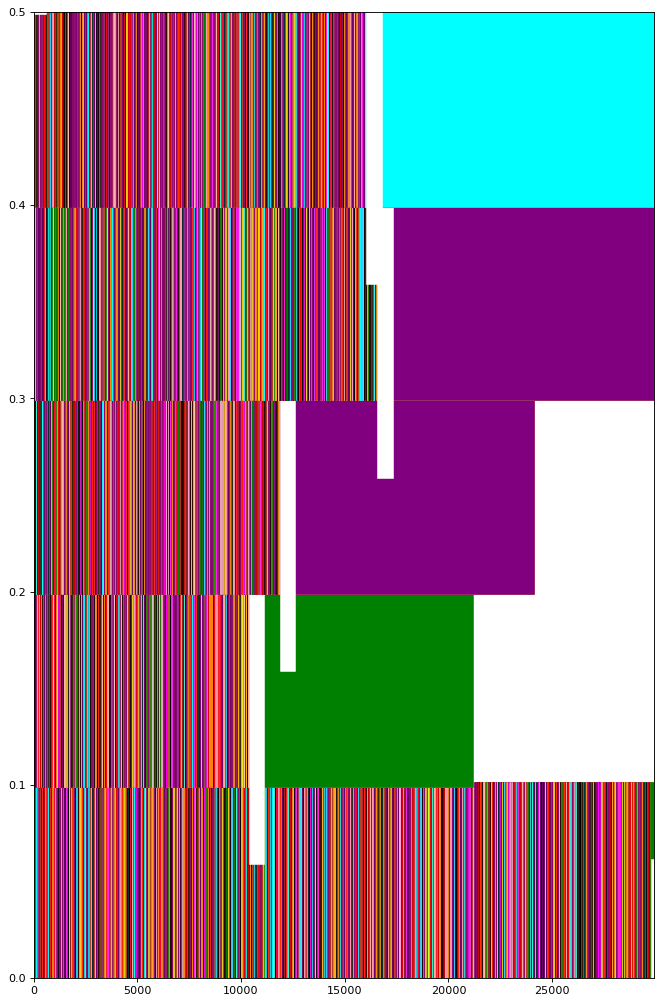

In [114]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

max_x = 0
num_sentences = 5

#define Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 16), dpi=80)

for p in range(0, num_sentences):
    parsed = []
    parsed.extend([w for w in list(plot[p]) if w.is_alpha])
    w_beg = 0
    w_end = 0
    
    for i in range(0, len(parsed)):
        #print(parsed[i].pos_)

        w_end = w_end + len(parsed[i])
        
        #update y axis max value
        if(w_end > max_x):
            max_x = w_end

        #assign each sentence word a color by type of word
        color = 'black'
        if(parsed[i].pos_ == "PRON"):
            color = 'pink'
        elif(parsed[i].pos_ == "VERB"):
            color = 'red'
        elif(parsed[i].pos_ == "CCONJ"):
            color = 'yellow'
        elif(parsed[i].pos_ == "PROPN"):
            color = 'green'
        elif(parsed[i].pos_ == "CCONJ"):
            color = 'blue'
        elif(parsed[i].pos_ == "AUX"):
            color = 'magenta'
        elif(parsed[i].pos_ == "ADV"):
            color = 'cyan'
        elif(parsed[i].pos_ == "DET"):
            color = 'brown'
        elif(parsed[i].pos_ == "NOUN"):
            color = 'purple'
        elif(parsed[i].pos_ == "ADP"):
            color = 'orange'
        #add rectangle to plot
        ax.add_patch(Rectangle((w_beg, (p*.1)), w_end, (p*.1)+.1, edgecolor = color,
                 facecolor = color,
                 fill=True,
                 lw=5))
        w_beg = w_end

    ax.add_patch(Rectangle((w_beg, (p*.1)-.04), 500, (p*.1)+.1, edgecolor = 'white',
             facecolor = 'white',
             fill=True,
             lw=5))

ax.add_patch(Rectangle((0, (p*.1)+.1), 500, 20, edgecolor = 'white',
         facecolor = 'white',
         fill=True,
         lw=5))

plt.xlim([0, max_x])
plt.ylim([0, num_sentences*.1])

#display plot
plt.show()

fig.savefig('vis.png', bbox_inches='tight', dpi=300)